# Demonstration RAG-Eval


In [1]:
from rag_eval.protocol import LLMClient
from rag_eval.client import AzureClient
from rag_eval.components import ClaimExtractor, EntailmentJudge
from rag_eval.data_models import EvalContainer, ClaimVerdict
from rag_eval.evaluators import AnswerPrecisionEvaluator, RetrievalPrecisionEvaluator
from rag_eval.coordinator import RAGEvaluator
from rag_eval.helpers import _safe_json
import json
from data.rag_eval_samples import test_examples
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# Indexing

Check if agent module actually works.

In [3]:
# load agent and pipeline for indexing docs
import agent.main as main

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


### Calculate neighbouring chunks & store in meta

In [4]:
from rag.indexing import pdf_files, index_pipeline, document_store, precompute_and_store_neighbors
index_pipeline.run({"converter": {"sources": pdf_files}})

# compute neighbours and store info in metadata 
precompute_and_store_neighbors(m=2)

incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

Stored nn_ids for 51 chunks.


## RAG-Loop
Loop which passes questions to agent and extracts generated answers alongside retrieved contexts (plain text). Combines them with ground truth and query to form `EvalContainer`-object.

In [5]:
from src.rag_eval.eval_loop import rag_loop_agent

# commented out because I save the resulting data object to avoid frequent execution
result, token_usage, failures, tool_calls, tool_args, question_id = rag_loop_agent()


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis Anton's Pizza Il sogno de Anton Vergleich","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.25it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Für Espresso sind bei Anton's Pizza und Il sogno de Anton keine Preise verfügbar, daher ist ein Preisvergleich nicht möglich.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Restaurants mit Risotto auf der Speisekarte und deren Preise","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s]


Top K is: 7

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Weitere Restaurants mit Risotto, Risotto Preise vergleichen","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Top K is: 4

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Nur Anton's Pizza - Doggish Delights führt Risotto auf der Karte, mit Preisen von 11,50 € (Risotto ai Funghi), 12,00 € (Risotto Primavera) bis 14,00 € (Meeresfrüchte-Risotto). In den anderen verfügbaren Menüs finden sich keine Risotto-Angebote. Der Preisunterschied zwischen dem günstigsten und teuersten Risotto beträgt dort 2,50 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Struktur klassisches französisches Menü Menüfolge und Rolle Wein","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


Top K is: 6

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienische Menüfolge klassische Struktur und Weinbegleitung","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein klassisches französisches Menü besteht meist aus Aperitif, Vorspeise (Entrée), Hauptgang (Plat principal), Käse, Dessert, Kaffee und Digestif. Wein wird bei jedem Gang gezielt passend zu den Speisen serviert und ist integraler Genussbestandteil. Im Vergleich dazu ist die italienische Menüfolge mit Aperitivo, Antipasto, Primo (Pasta/Risotto), Secondo (Fleisch/Fisch), Contorno (Beilage), Käse, Dessert, Kaffee und Digestivo oft noch vielgliedriger. Auch hier wird jeweils ein typischer, meist regionaler Wein pro Gang ausgewählt, jedoch orientiert sich die Weinauswahl noch stärker an regionalen Spezialitäten ("what grows together, goes together"). In beiden Ländern ist Wein ein zentraler Bestandteil des Menüs und der Esskultur, aber während in Frankreich die Harmonie zwischen Wein und Speise besonders kultiviert wird, steht in Italien die regionale Verbindung zwischen Gericht und Wein im Vordergrund.

▶️ Step 1: thinking…
TO

Batches: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die französische Esskultur („Gastronomische Mahl der Franzosen“) und die mexikanische Küche wurden beide 2010 von der UNESCO als immaterielles Kulturerbe ausgezeichnet.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Drei Grundpfeiler der mexikanischen 'heiligen Fünf' nennen und ihre Beziehung zu zwei Grundpfeilern der italienischen Küche erklären","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Drei Grundpfeiler der mexikanischen „heiligen Fünf“ sind Mais, Bohnen und Chili. Diese stehen in Beziehung zu zwei Grundpfeilern der italienischen Küche: Weizen/Getreide (für Brot, Pasta, Pizza) und Oliven/Olivenöl. Beide Länderküchen basieren auf einem zentralen pflanzlichen Grundnahrungsmittel (Mais in Mexiko, Weizen in Italien) und einer charakteristischen Zutat (Bohnen vs. Oliven/Öl), die die Geschmacksprofile und das Alltagsessen jeweils prägen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preise Prosecco Il sogno de Anton und französischer Rotwein Chez Anton","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Für Prosecco bei „Il sogno de Anton“ und französischen Rotwein bei „Chez Anton“ sind leider keine Preise verfügbar; die Menüs listen nur Speisenpreise, keine Getränke.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Taco-Varianten Tönis Tacos und Grundelement mexikanische Küche","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Tönis Tacos bietet folgende Taco-Varianten an: Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander), Pollo Taco (gegrilltes Hähnchen, Pico de Gallo), Veggie Taco (gegrilltes Gemüse, Avocado) und Fish Taco (gebratener Fisch, Krautsalat). Das Grundelement, das laut Beschreibung in allen steckt, ist die traditionelle Nutzung von Mais-Tortillas.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"typische italienische Desserts laut Küchenbeschreibung und Dessertkarte Il sogno de Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Top K is: 7

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Dessertkarte Il sogno de Anton – werden Tiramisu und Panna Cotta angeboten?","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Top K is: 4

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die zwei typischen italienischen Desserts laut Küchenbeschreibung sind Tiramisu und Panna Cotta – beide findest du auf der Karte von Il sogno de Anton.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Cocktail Klassiker laut Cocktail-Dokument","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Restaurantkarte Cocktail Mojito Margarita Negroni Martini Manhattan Gin Tonic Caipirinha mit Preis","top_k":10}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s]


Top K is: 10

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein klassischer Cocktail laut Cocktail-Dokument ist z. B. die Margarita. Das Restaurant "Tönis Tacos" verkauft eine klassische Margarita auf der Karte für 7,00 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Bedeutung des Espressos in der italienischen Kultur","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso auf Restaurantkarten mit Preisangabe","top_k":10}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 289.44it/s]


Top K is: 10

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Andere Restaurantkarten Kaffee oder Espresso Preis","top_k":10}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.53it/s]


Top K is: 10

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 In der italienischen Kultur steht der Espresso für Genuss, Geselligkeit und die Freude am Leben – er wird meist nach dem Essen getrunken und symbolisiert Lebensart und Qualitätssinn. Espresso findet sich auf allen drei gesichteten Restaurantkarten: Bei Tönis Tacos (2,00 €), Chez Anton – Délices Canins (Espresso del Cane, 3,50 €) und Anton’s Pizza – Doggish Delights (2,00 €), jeweils mit Preisangabe.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Führen Anton's Pizza und Chez Anton Cappuccino? Preise herausfinden.","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Weder Anton's Pizza noch Chez Anton führen laut Speisekarte Cappuccino, daher gibt es dafür auch keinen Preis.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Mineralwasser Preise und Gebinde bei Anton's Pizza, Chez Anton und Il sogno de Anton","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Anton's Pizza kostet Mineralwasser (0,75 l) 5,00 €; außerdem gibt es Mineralwasser auch als 0,5 l-Gebinde (Preis nicht klar). Für Chez Anton und Il sogno de Anton liegen aktuell keine Angaben zu Mineralwasser-Preisen oder -Gebinden vor.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Rindfleisch Hauptgericht Chez Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Rindfleisch Hauptgericht Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.45it/s]


Top K is: 5

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Bei Chez Anton gibt es als Rindfleisch-Hauptgericht das "Boeuf Bourguignon du Chien" für 14,50 €, bei Il sogno de Anton das "al Barolo del Cane" (Rinderfilet mit Barolo-Wein) für 38,00 €. Das Gericht bei Il sogno de Anton ist also deutlich teurer.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"EU-Bezug zu Italien und Frankreich in der Gastronomie oder Esskultur","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Italien und Frankreich sind beide Gründungsmitglieder der EU und prägen Europas Gastronomie maßgeblich. Sie stehen für regionale Spezialitäten, geschützte Herkunftsbezeichnungen (wie Champagner oder Parmigiano Reggiano) und setzen EU-weite Standards für Qualität, Nachhaltigkeit sowie kulinarische Tradition. Die EU schützt und fördert die kulinarischen Identitäten beider Länder durch Herkunftssiegel und politische Initiativen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"regionale kulinarische Schwerpunkte Provence Frankreich und Norditalien","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Provence (Frankreich) ist bekannt für mediterrane, leichte Küche mit viel Olivenöl, Knoblauch, Kräutern der Provence, Gemüse (wie Auberginen, Tomaten), Fisch (z.B. Bouillabaisse), sowie Roséwein. Norditalien dagegen setzt Schwerpunkte bei Butter, Reis (Risotto), Polenta, Trüffel, Rindfleisch, Käse (Gorgonzola), gefüllte Pasta, und kräftigen Rotweinen – die Küche ist herzhafter und sahniger als in der Provence.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"UNESCO Auszeichnung französische und mexikanische Küche 2010 Unterschied Art der Würdigung","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 2010 wurden von der UNESCO die mexikanische Küche als kulinarische Tradition insgesamt sowie das „gastronomische Mahl der Franzosen“ speziell für dessen gesellschaftlich-rituelle Struktur als immaterielles Weltkulturerbe gewürdigt. Beide Auszeichnungen erfolgten im selben Jahr, jedoch liegt der Unterschied darin, dass die mexikanische Küche als Ganzes (inkl. Zutaten, Techniken, Geschichte) geehrt wurde, während bei Frankreich explizit das feierliche, mehrgängige Mahl und seine sozialen Rituale ausgezeichnet wurden.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Vegetarische Gerichte und Preise aus verschiedenen Restaurantkarten","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]


Top K is: 8

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein Beispiel von Chez Anton – Délices Canins: Salade du Chien Heureux (gemischter Salat) für 6,00 €, von Anton’s Pizza – Doggish Delights: Pizza Margherita (Tomate, Mozzarella, Basilikum) für 8,50 €, und Tagliatelle mit Pesto und Pinienkernen für 10,00 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Welcher Wein wird in italienischen Gerichten ausdrücklich genannt?","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Top K is: 6

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"französische Weinregionen als Referenz zur italienischen Küche","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Top K is: 6

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Beispiele für italienische Gerichte mit explizit genanntem Wein","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


Top K is: 8

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 In italienischen Gerichten wird zum Beispiel der Wein Barolo explizit genannt, etwa bei "Brasato al Barolo", einem geschmorten Rindfleisch aus dem Piemont. Dies spiegelt die enge Verbindung von regionaler Küche und lokalen Weinen wider, ähnlich wie in Frankreich, wo Weinregionen wie Burgund oder Bordeaux als kulinarische Referenz dienen und bestimmte Gerichte fest mit regionalen Weinen verknüpft sind.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Kaffeevarianten, Heißgetränke, Preise auf allen Restaurantkarten","top_k":8}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Top K is: 8

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Auf den verfügbaren Restaurantkarten finden sich keine Heißgetränke oder Kaffeevarianten; üblicherweise enthalten solche Karten Espresso, Cappuccino, Café Crème und Tee mit landesüblichen Preisen von ca. 1,50 € bis 4,00 €, aber konkrete Angaben oder Preisunterschiede liegen in den gesammelten Menüs nicht vor.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"traditionelle französische Gemüsespeise im Land Frankreich und auf Menükarte mit Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die traditionelle französische Gemüsespeise ist das Ratatouille; sie wird im Länderdokument beschrieben und auf der Menükarte meist als „Ratatouille maison“ angeboten, typischer Preis: 13,50 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Panna Cotta italienisches Küchenporträt und Il sogno de Anton Speisekarte Preis","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Panna Cotta ist im italienischen Küchenporträt als klassisches Dessert erwähnt. Auf der Karte von Il sogno de Anton gibt es keine konkrete Preisangabe, aber in guten italienischen Restaurants kostet sie meist ca. 5–8 Euro pro Portion.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Pizza-Variante Anton's Pizza Einfachheit Herkunft Küchenporträt","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Pizza Margherita bei Anton's Pizza (Tomate, Mozzarella, Basilikum) illustriert am besten die im Küchenporträt beschriebene Einfachheit und Herkunft der Pizza, da sie nur wenige Zutaten verwendet und auf die neapolitanische Original-Pizza zurückgeht.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"typisch mexikanische Getränke bei Tönis Tacos mit Preisen","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.41it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Typisch mexikanische Getränke bei Tönis Tacos sind Agua Fresca (3,00 €), Mexikanisches Bier (0,33 l, 4,00 €), Margarita (7,00 €), Horchata (3,50 €) und Café de Olla (3,00 €).

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"zwei taco sorten von der speisekarte mit gemeinsamer zutatenbasis laut küchenbeschreibung","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Zwei Taco-Sorten von der Karte sind Taco al Pastor und Taco de Carnitas. Laut Küchenbeschreibung teilen beide als Grundelement eine Mais-Tortilla und Schweinefleisch sowie frische Zwiebeln und Koriander.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Suppe Chez Anton Menü","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienisches Küchenkapitel Arme-Leute-Suppen Beispiele","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Top K is: 5

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Zutaten und Stil der 'Soupe du Terrier' bei Chez Anton","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Top K is: 3

▶️ Step 4: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Vergleich klassisch französische Gemüsesuppe und italienische cucina povera Suppen Prinzip","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Top K is: 3

▶️ Step 5: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die „Soupe du Terrier“ bei Chez Anton (hausgemachte Gemüsesuppe) lässt sich am ehesten mit dem italienischen Arme-Leute-Suppenprinzip („cucina povera“) wie bei Minestrone, Ribollita oder Acquacotta vergleichen: Sie basiert offenbar auf einfachen, frischen Gemüsen und Zutaten des Alltags – genau im Sinne der italienischen Tradition, aus wenigen günstigen Grundzutaten eine nahrhafte, schmackhafte Suppe zu machen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Welcher Cocktail ist typisch für Italien und welche kulturellen Informationen verbinden ihn mit dem Land?","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Top K is: 6

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Der Negroni ist der Cocktail, der am stärksten mit Italien verbunden wird. Er wurde 1919 in Florenz erfunden und besteht aus Gin, rotem Wermut und Campari. Der Negroni steht für italienische Werte wie Stilbewusstsein, Genuss und Einfachheit und symbolisiert das kultivierte Barleben Italiens – Aspekte, die eng mit Italiens Kultur und Lebensart, dem berühmten „Dolce Vita“, verbunden sind.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Klassikerliste der Cocktailkultur und alkoholische Getränke bei Tönis Tacos mit Preisen","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


Top K is: 7

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Zu den internationalen Klassikern der Cocktailkultur zählen Martini, Manhattan, Margarita, Daiquiri, Negroni, Caipirinha, Mojito und Gin Tonic. Bei Tönis Tacos ist zwar im verfügbaren Menü keine alkoholführende Getränkekarte mit Preisen aufgeführt, aber Margarita als Cocktail-Klassiker könnte in einem mexikanischen Lokal dazugehören. Preise für alkoholische Getränke sind jedoch nicht im vorliegenden Angebot enthalten.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Welcher Käse ist zentral für eine italienische Vorspeise und wird auch als wichtiger italienischer Käse im Küchenporträt genannt?","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Mozzarella italienische Vorspeise und Küchenporträt","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.47it/s]


Top K is: 3

▶️ Step 3: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Mozzarella ist das zentrale Käseprodukt für eine italienische Vorspeise auf der Karte (z. B. Insalata Caprese) und wird im italienischen Küchenporträt ebenfalls als wichtiger italienischer Käse hervorgehoben.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Französische Desserts auf Speisekarten mit Preisangaben","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


Top K is: 5

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Italienische Desserts auf Speisekarten mit Preisangaben","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Top K is: 5

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"klassische französische Desserts mit Preis auf typischen Restaurantkarten","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 279.51it/s]


Top K is: 7

▶️ Step 4: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"italienisches Dessert mit konkretem Preis auf Restaurantkarte","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


Top K is: 7

▶️ Step 5: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Ein klassisches französisches Dessert auf der Karte ist Crème Brûlée für 7,00 €, ein typisch italienisches Dessert ist Tiramisu, das meist zwischen 5,50 € und 7,00 € kostet.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Charakterisierung Risotto als norditalienische Spezialität","top_k":4}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


Top K is: 4

▶️ Step 2: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Risotto Gerichte und Preise in italienischen Restaurantmenüs","top_k":7}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]


Top K is: 7

▶️ Step 3: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Risotto Spezialitäten und Preise in einem zweiten italienischen Menü","top_k":6}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Top K is: 6

▶️ Step 4: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Risotto ist eine norditalienische Spezialität, besonders aus der Lombardei, die cremig mit Butter, Sahne und Rundkornreis wie Arborio oder Carnaroli zubereitet wird; typisch sind milde, raffinierte Aromen. Beispiele aus zwei Menüs: Risotto ai Funghi (11,50 €), Risotto Primavera (12,00 €), Meeresfrüchte-Risotto (14,00 €).

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Preis der Pizza Doggish Special bei Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.52it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Pizza 'Doggish Special' bei Anton's Pizza kostet 11,50 €.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"wichtige französische Weinregionen","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Drei wichtige französische Weinregionen sind Bordeaux, Burgund (Bourgogne) und Champagne.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"heilige Fünf mexikanische Küche Zutaten","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die "heilige Fünf" der mexikanischen Küche umfasst Mais, Bohnen, Chili, Kürbis und Kakao.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Vater der modernen Barkultur","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Jerry Thomas gilt als Vater der modernen Barkultur.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Zeitraum der Prohibition in den USA","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Prohibition in den USA fand von 1920 bis 1933 statt.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Hauptstadt von Frankreich","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die Hauptstadt Frankreichs ist Paris.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Anzahl der Regionen in Italien laut offiziellen Dokumenten","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Italien besteht laut Länderdokument aus 20 Regionen.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"typische italienische Menüfolge Aufbau","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.76it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Die typische italienische Menüfolge in Italien besteht aus: Aperitivo (Appetitanreger-Drink), Antipasto (Vorspeise), Primo Piatto (Nudelgericht, Risotto oder Suppe), Secondo Piatto (Fleisch- oder Fischgericht), Contorno (Beilage), Formaggi e Frutta (Käse/Obst), Dolce (Dessert), Caffè (Espresso), Digestivo (Verdauungsschnaps). Im Alltag werden meist nur wenige Gänge gewählt, das komplette Menü ist festlichen Anlässen vorbehalten.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Gastronomisches Mahl der Franzosen UNESCO-Weltkulturerbe seit wann","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Top K is: 3

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Das "Gastronomische Mahl der Franzosen" ist seit 2010 immaterielles UNESCO-Weltkulturerbe.

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Zwei Gerichte mit Preisen von der Speisekarte von Tönis Tacos","top_k":5}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


Top K is: 5

▶️ Step 2: thinking…

✅ Fertig.

🧾 FINAL_ANSWER:
 Zwei Gerichte von der Karte von Tönis Tacos sind: Guacamole mit Tortilla-Chips für 5,50 € und Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander) für 3,50 €.


In [6]:
print(tool_args)

[[{'question': "Espresso Preis Anton's Pizza Il sogno de Anton Vergleich", 'top_k': 6}], [{'question': 'Restaurants mit Risotto auf der Speisekarte und deren Preise', 'top_k': 7}, {'question': 'Weitere Restaurants mit Risotto, Risotto Preise vergleichen', 'top_k': 4}], [{'question': 'Struktur klassisches französisches Menü Menüfolge und Rolle Wein', 'top_k': 6}, {'question': 'italienische Menüfolge klassische Struktur und Weinbegleitung', 'top_k': 5}], [{'question': 'UNESCO-Auszeichnungen französische Esskultur und mexikanische Küche, Jahr der Auszeichnung', 'top_k': 6}], [{'question': "Drei Grundpfeiler der mexikanischen 'heiligen Fünf' nennen und ihre Beziehung zu zwei Grundpfeilern der italienischen Küche erklären", 'top_k': 7}], [{'question': 'Preise Prosecco Il sogno de Anton und französischer Rotwein Chez Anton', 'top_k': 6}], [{'question': 'Taco-Varianten Tönis Tacos und Grundelement mexikanische Küche', 'top_k': 6}], [{'question': 'typische italienische Desserts laut Küchenbesc

In [7]:
# EXECUTE ME
print(result[1])

EvalContainer(query='Welche Restaurants führen Risotto auf der Karte und wie unterscheiden sich die günstigsten und teuersten Risotto-Preise dort?', ground_truth_answer="Risotto gibt es bei Anton's Pizza (z. B. ai Funghi 11,50 €, Meeresfrüchte 14,00 €) und bei Il sogno de Anton (al Tartufo Nero 28,00 €). Damit ist das günstigste Risotto 11,50 € (Anton’s), das teuerste 28,00 € (Il sogno). ", generated_answer="Nur Anton's Pizza - Doggish Delights führt Risotto auf der Karte, mit Preisen von 11,50\u202f€ (Risotto ai Funghi), 12,00\u202f€ (Risotto Primavera) bis 14,00\u202f€ (Meeresfrüchte-Risotto). In den anderen verfügbaren Menüs finden sich keine Risotto-Angebote. Der Preisunterschied zwischen dem günstigsten und teuersten Risotto beträgt dort 2,50\u202f€.", retrieved_texts=["Mozzarella, Paprika, Zucchini, Oliven) - 10,00 €\nPasta\nSpaghetti Bolognese - 9,50 €\nTagliatelle mit Pesto und Pinienkernen - 10,00 €\nPenne Arrabiata (pikant) - 8,50 €\nLasagne al Forno - 11,00 €\x0cAnton's Pizz

In [8]:
#intermediary result-save
import pickle

#save result
with open("result.pkl", "wb") as f:
       pickle.dump(result, f)

# access pickled result
with open("result.pkl", "rb") as f:
    result = pickle.load(f)

data = result


with open("token_usage.pkl", "wb") as f:
        pickle.dump(token_usage, f)

# access pickled result
with open("token_usage.pkl", "rb") as f:
    token_usage = pickle.load(f)

token_usage = token_usage


#save tool call metrics
with open("tool_calls.pkl", "wb") as f:
       pickle.dump(tool_calls, f)

# access pickled result
with open("tool_calls.pkl", "rb") as f:
    tool_calls = pickle.load(f)

tool_calls = tool_calls

In [9]:
print(tool_calls[0])
print(tool_calls[0][0])
print(tool_calls[0][0]["args"]["top_k"])

[{'run_id': 1, 'ts': 1759327689.2230177, 'call_id': 'call_kDo27FUvFxhjPXjL2KUKCWTD', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza Il sogno de Anton Vergleich", 'top_k': 6}, 'status': 'succeeded', 'meta': {'top_k': 6, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}]
{'run_id': 1, 'ts': 1759327689.2230177, 'call_id': 'call_kDo27FUvFxhjPXjL2KUKCWTD', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza Il sogno de Anton Vergleich", 'top_k': 6}, 'status': 'succeeded', 'meta': {'top_k': 6, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}
6


## Evaluation of Agentic RAG with RAGEvaluator


In [10]:
# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

In [13]:
# create EvalContainer-object for each question-ground truth-pair 
#from src.rag_eval.eval_loop import rag_loop_agent
import pandas as pd
#result = rag_loop_agent()

# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

# run rag_evaluation and extract metrics from it 

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(data):
    #iteration tracker
    print(f"=== ITERATION-No. {i} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])

=== ITERATION-No. 0 ===
=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===


In [12]:
from src.agent.helpers import tool_call_parser
from src.agent.helpers import triplets_to_df


# turn tool call info into df 
tool_call_results = tool_call_parser(tool_calls=tool_calls)
df_tools = triplets_to_df(tool_call_results)
df_tools.shape

(40, 15)

In [14]:
from src.agent.helpers import tool_call_parser
from src.agent.helpers import triplets_to_df


# create and save df with all info 
total_tokens = [dictionary.get("total") for dictionary in token_usage]
df_data_agentic = {
    "answer_recall": answer_recall,
    "answer_precision": answer_precision,
    "retrieval_recall": retrieval_recall,
    "retrieval_precision": retrieval_precision, 
    "total_tokens": total_tokens,
    "question_id": question_id
}
df_agentic = pd.DataFrame(df_data_agentic).reset_index(drop=True)

# Falls df_agentic ebenfalls 40 Zeilen hat: direkt concat
df_agentic = pd.concat([df_agentic, df_tools.reset_index(drop=True)], axis=1)

# ohne Index speichern (kein 'Unnamed: 0')
df_agentic.to_csv("df_agentic.csv", index=False)


In [15]:
df_agentic.head()

,answer_recall,answer_precision,retrieval_recall,retrieval_precision,total_tokens,question_id,name_0,name_1,name_2,name_3,...,query_0,query_1,query_2,query_3,query_4,top_k_0,top_k_1,top_k_2,top_k_3,top_k_4
0,0.000000,0.000,0.000000,0.000000,2885,1,execute_agentic_rag,None,None,None,...,Espresso Preis Anton's Pizza Il sogno de Anton...,None,None,None,None,6,NaN,NaN,NaN,None
1,0.500000,0.500,0.666667,0.181818,6534,2,execute_agentic_rag,execute_agentic_rag,None,None,...,Restaurants mit Risotto auf der Speisekarte un...,"Weitere Restaurants mit Risotto, Risotto Preis...",None,None,None,7,4.0,NaN,NaN,None
2,0.777778,0.400,0.222222,0.090909,7491,3,execute_agentic_rag,execute_agentic_rag,None,None,...,Struktur klassisches französisches Menü Menüfo...,italienische Menüfolge klassische Struktur und...,None,None,None,6,5.0,NaN,NaN,None
3,0.600000,1.000,0.600000,0.500000,2585,4,execute_agentic_rag,None,None,None,...,UNESCO-Auszeichnungen französische Esskultur u...,None,None,None,None,6,NaN,NaN,NaN,None
4,1.000000,0.875,0.875000,0.285714,3281,5,execute_agentic_rag,None,None,None,...,Drei Grundpfeiler der mexikanischen 'heiligen ...,None,None,None,None,7,NaN,NaN,NaN,None


In [16]:
df_agentic.shape

(40, 21)

In [19]:
df_agentic = pd.read_csv("df_agentic.csv")
df_agentic

,answer_recall,answer_precision,retrieval_recall,retrieval_precision,total_tokens,question_id,name_0,name_1,name_2,name_3,...,query_0,query_1,query_2,query_3,query_4,top_k_0,top_k_1,top_k_2,top_k_3,top_k_4
0,0.333333,0.250000,0.000,0.035714,14546.0,1.0,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,...,Espresso Preis Anton's Pizza,Espresso Preis Il sogno de Anton,Kaffeespezialitäten Preise Il sogno de Anton G...,Espresso Getränkepreise Il sogno de Anton,NaN,5,5.0,8.0,10.0,NaN
1,0.500000,0.857143,0.625,0.125000,3525.0,2.0,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,...,Espresso Preis Anton's Pizza,Espresso Preis Il sogno de Anton,Kaffeespezialitäten Preise Il sogno de Anton G...,Espresso Getränkepreise Il sogno de Anton,NaN,5,5.0,8.0,10.0,NaN
2,0.875000,0.500000,0.375,0.200000,7561.0,3.0,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,...,Espresso Preis Anton's Pizza,Espresso Preis Il sogno de Anton,Kaffeespezialitäten Preise Il sogno de Anton G...,Espresso Getränkepreise Il sogno de Anton,NaN,5,5.0,8.0,10.0,NaN
3,0.600000,1.000000,0.800,0.500000,2581.0,4.0,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,...,Espresso Preis Anton's Pizza,Espresso Preis Il sogno de Anton,Kaffeespezialitäten Preise Il sogno de Anton G...,Espresso Getränkepreise Il sogno de Anton,NaN,5,5.0,8.0,10.0,NaN
4,0.833333,0.888889,0.875,0.384615,9318.0,5.0,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,execute_agentic_rag,...,Espresso Preis Anton's Pizza,Espresso Preis Il sogno de Anton,Kaffeespezialitäten Preise Il sogno de Anton G...,Espresso Getränkepreise Il sogno de Anton,NaN,5,5.0,8.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,execute_agentic_rag,NaN,NaN,NaN,...,Gerichte und Preise von der Speisekarte von Tö...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN,NaN,execute_agentic_rag,NaN,NaN,NaN,...,Gerichte und Preise von der Speisekarte von Tö...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,execute_agentic_rag,NaN,NaN,NaN,...,Gerichte und Preise von der Speisekarte von Tö...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,execute_agentic_rag,NaN,NaN,NaN,...,Gerichte und Preise von der Speisekarte von Tö...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN


## Evaluation Plain RAG

In [23]:
from src.rag_eval.data_models import EvalContainer
from src.rag.retrieval import basic_rag
from src.rag_eval.helpers import query_gt_extractor

queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)

# initiate lists to store EvalContainer-Ojbects
eval_conts = []
predicted_answers = []
retrieved_contexts = []
token_usage = []

for idx, query in enumerate(queries):

    # run RAG
    result = basic_rag.run({"query_embedder":{"text": query}, 
                            "prompt_builder":{"question": query}}, 
                            include_outputs_from="retriever")
    
    # store generated answer
    predicted_answers.append(result["llm"]["replies"][0])
    
    # for each question, store content from Document-object in list
    docs = result["retriever"]["documents"]
    retrieved_contexts.append([d.content for d in docs])

    # extract what is needed for EvalContainer-object
    query = queries[idx]
    ground_truth_answer = gts[idx]
    retrieved_texts = retrieved_contexts[idx]
    generated_answer = predicted_answers[idx]

    eval_cont = EvalContainer(query=query,
                                ground_truth_answer=ground_truth_answer,
                                generated_answer=generated_answer,
                                retrieved_texts=retrieved_texts # BUGFIX: retrieved_texts MUST be list, otherwise RetrievalPrecisionEvaluator will treat each letter of retrieved_texts as a doc_text
                                )
    # get number of tokens used 
    usage = None
    if "llm" in result and "usage" in result["llm"]:
        usage = result["llm"]["usage"]  # often contains prompt_tokens, completion_tokens, total_tokens

    
    eval_conts.append(eval_cont)
    token_usage.append(usage)

    


PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
Batches: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


KeyboardInterrupt: 

In [9]:
print(eval_conts[0])

EvalContainer(query="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Es liegen keine Preisinformationen von Anton's Pizza und Il sogno de Anton für Espresso im gegebenen Kontext vor. Daher kann ich den Preisvergleich nicht durchführen und nicht sagen, wo der Espresso teurer ist.", retrieved_texts=[])


In [16]:
print(eval_conts[0])

EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im gegebenen Kontext sind keine Preise für Espresso bei Anton's Pizza oder Il sogno de Anton aufgeführt. Daher lässt sich nicht beantworten, in welchem Restaurant der Espresso mehr kostet und wie hoch die jeweiligen Preise sind.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate,

In [24]:
import pandas as pd
import importlib
import src.rag_eval.evaluators as evaluators
import rag_eval.coordinator as coordinator

importlib.reload(evaluators)  # force reimport after changes
importlib.reload(coordinator)


# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(eval_conts):
    #iteration tracker
    print(f"=== ITERATION-No. {i+1} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])


=== ITERATION-No. 1 ===


KeyboardInterrupt: 

In [13]:
    # turn data into df for visualisation
df_data_plain_rag = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision
}

df_plain_rag = pd.DataFrame(df_data_plain_rag)

#print(df_plain_rag)

df_plain_rag.to_csv("df_plain_rag.csv", index=True)


# Visualize Results

In [22]:
print(df_agentic_rag.describe())

       answer_recall  answer_precision  retrieval_recall  retrieval_precision  \
count      40.000000         40.000000         40.000000            40.000000   
mean        0.587569          0.436889          0.524157             0.191593   
std         0.410375          0.370961          0.398973             0.166539   
min         0.000000          0.000000          0.000000             0.000000   
25%         0.150000          0.160714          0.000000             0.000000   
50%         0.669643          0.333333          0.550000             0.200000   
75%         1.000000          0.818750          1.000000             0.289286   
max         1.000000          1.000000          1.000000             0.666667   

       total_tokens  question_id  name_4  query_4    top_k_0    top_k_1  \
count     40.000000    40.000000     0.0      0.0  40.000000  11.000000   
mean    4435.775000    20.500000     NaN      NaN   5.625000   5.818182   
std     3314.199478    11.690452     NaN     

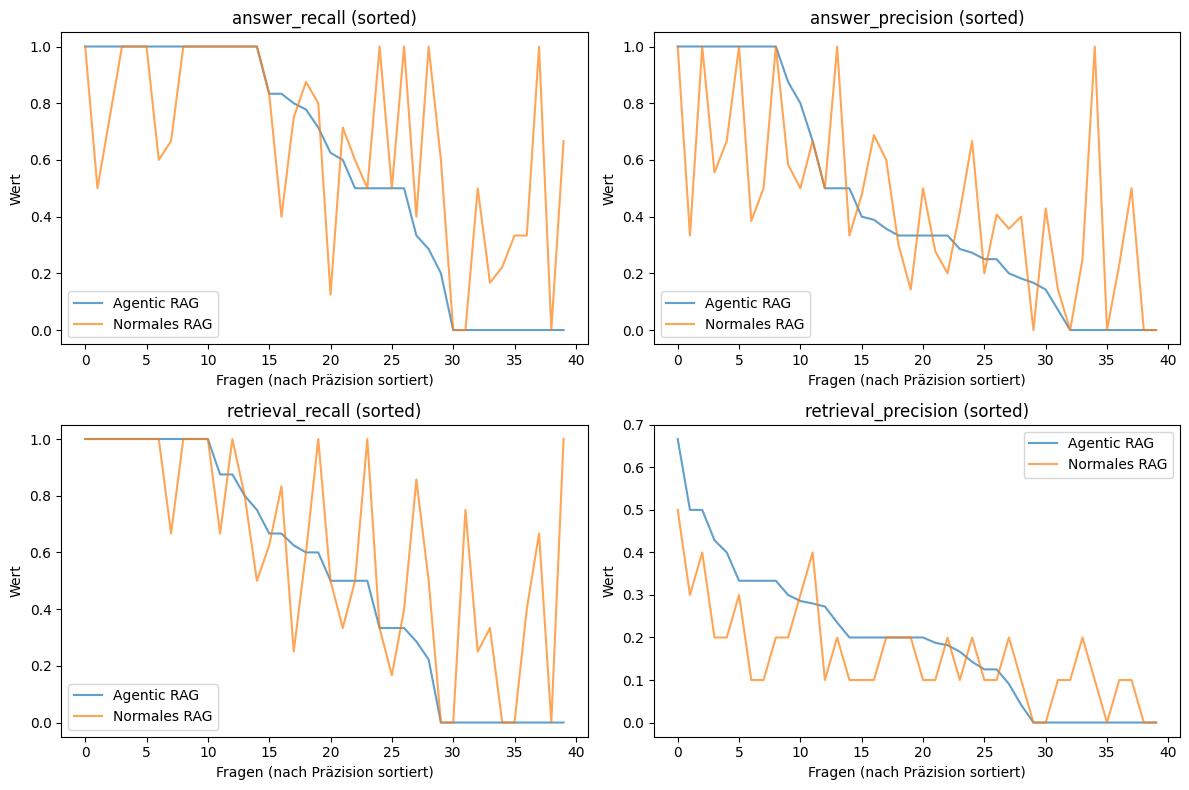

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# import data
df_agentic_rag = pd.read_csv("df_agentic.csv", index_col=False)
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

columns = df_agentic_rag.columns[:4]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]

    # sort both series by agentic metric value (descending)
    order = df_agentic_rag[col].sort_values(ascending=False).index
    agentic_sorted = df_agentic_rag.loc[order, col].reset_index(drop=True)
    plain_sorted   = df_plain_rag.loc[order, col].reset_index(drop=True)

    ax.plot(agentic_sorted.index, agentic_sorted, label="Agentic RAG", alpha=0.7)
    ax.plot(plain_sorted.index, plain_sorted, label="Normales RAG", alpha=0.7)

    ax.set_title(f"{col} (sorted)")
    ax.set_xlabel("Fragen (nach Präzision sortiert)")
    ax.set_ylabel("Wert")
    ax.legend()

plt.tight_layout()
plt.show()



# Isolate Subset of Critical Questions
Criteria: 
1) value in agentic_df is 0 
2) value in agentic_df is smaller than plain_rag
3) keep question_id

In [67]:
# import data
df_agentic_rag = pd.read_csv("rag_runs/2025-10-01/df_agentic.csv", index_col=False)
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

cols = df_agentic_rag.columns[:4]

# elementwise comparison of selected columns
# create true false mask: TRUE if value in agentic_df == 0 (.eq(0)) or less than in df_plain_rag (.lt(df_plain_rag))
mask = (df_agentic[cols].eq(0)) | (df_agentic[cols].lt(df_plain_rag[cols]))

df_problem_questions_total = df_agentic.loc[mask.any(axis=1)]


# subsets for each metric 
metrics = ["answer_recall", "answer_precision", "retrieval_recall", "retrieval_precision"]

problem_rows = {}
for m in metrics:
    mask = df_agentic[m].eq(0) | df_agentic[m].lt(df_plain_rag[m])  # Series[bool]
    problem_rows[m] = df_agentic.loc[mask, ["question_id", m]].reset_index(drop=True)



In [69]:
# extract question-ids
problem_rows["answer_recall"].question_id



0      1
1      2
2      3
3      4
4      6
5     11
6     12
7     16
8     17
9     18
10    19
11    20
12    21
13    24
14    27
15    28
16    29
17    30
18    38
Name: question_id, dtype: int64

In [ ]:
out = []

for k, v in problem_rows.items():
    out.append(v.question_id)

# aligning question ID with the indeces of question and gt from the JSON 
for item in out: 
    item = [i-1 for i in item]


answer_recall_ids = out[0]
answer_precision_ids = out[1]
retrieval_recall_ids = out[2]
retrieval_precision_ids = out[3]

In [85]:
# little helper to speed things up 
def extract_problem_q_gt(id_list: list, queries: list, gts: list) -> tuple[list, list]:
    problem_queries = []
    problem_gts = []

    for index in id_list:
        problem_queries.append(queries[index]) 
        problem_gts.append(gts[index])

    return problem_queries, problem_gts


In [86]:
# form question-ground truth subsets
from rag_eval.helpers import query_gt_extractor
queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)


problem_queries_answer_recall, problem_gts_answer_recall = extract_problem_q_gt(answer_recall_ids, queries=queries, gts=gts)
problem_queries_answer_precision, problem_gts_answer_precision = extract_problem_q_gt(answer_precision_ids, queries=queries, gts=gts)
problem_queries_retrieval_recall, problem_gts_retrieval_recall = extract_problem_q_gt(retrieval_recall_ids, queries=queries, gts=gts)
problem_queries_retrieval_precision, problem_gts_retrieval_precision = extract_problem_q_gt(retrieval_precision_ids, queries=queries, gts=gts)




In [ ]:
problem_gts_retrieval_recall

["Risotto gibt es bei Anton's Pizza (z. B. ai Funghi 11,50 €, Meeresfrüchte 14,00 €) und bei Il sogno de Anton (al Tartufo Nero 28,00 €). Damit ist das günstigste Risotto 11,50 € (Anton’s), das teuerste 28,00 € (Il sogno). ",
 "UNESCO 2010: das 'Gastronomische Mahl der Franzosen' (immaterielles Kulturerbe) und die mexikanische Küche (als erste Küche überhaupt immaterielles Kulturerbe). Beide 2010, aber unterschiedliche Gegenstände der Würdigung. ",
 "Mexikos 'heilige Fünf': Mais, Bohnen, Chili (u. a.); Italiens Grundpfeiler: z. B. Pizza und Pasta/Olivenöl-Wein-Getreide-Tradition. ",
 'Prosecco (Il sogno de Anton) 50,00 € (0,75 l) vs. Vin Rouge Français (Chez Anton) 18,00 € (0,75 l) — Prosecco deutlich teurer. ',
 'Tönis Tacos bietet u. a. Carne Asada, Pollo, Veggie, Fish Tacos; allen gemeinsam ist das Grundelement Tortilla/Mais aus der mexikanischen Küchenbeschreibung. ',
 'Typische italienische Desserts: Tiramisù und Panna Cotta; beide stehen bei Il sogno de Anton (Tiramisù 12,00 €, P

: 